# Prerequisites

## Storing my credentials

In [1]:
import json

# Set up credentials file
credentials = {}
credentials['CONSUMER_KEY'] = "ADD CONSUMER KEY"
credentials['CONSUMER_SECRET'] = "ADD CONSUMER SECRET"
credentials['ACCESS_TOKEN'] = "ADD ACCESS TOKEN"
credentials['ACCESS_SECRET'] = "ADD ACCESS SECRET"

# Store credentials
with open("twitter_credentials.json", "w") as file:
    json.dump(credentials, file)

## Making the connection

In [2]:
import tweepy

# Read credentials as json file
with open("twitter_credentials.json", "r") as file:
    creds = json.load(file)

# Authenticate to Twitter
auth = tweepy.OAuthHandler(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])
auth.set_access_token(creds['ACCESS_TOKEN'], creds['ACCESS_SECRET'])
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# test authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


# Getting Trump and Biden's latest Tweets 

## Making the query and storing the results in a DataFrame

In [3]:
# Define a query and store the results as a json
Biden_json = api.search(q='from:@JoeBiden', result_type='recent', 
                           count=100, exclude='retweets', 
                           lang='en', tweet_mode='extended')

Trump_json = api.search(q='from:@realDonaldTrump', result_type='recent', 
                           count=100, exclude='retweets', 
                           lang='en', tweet_mode='extended')

# Call pandas to handle the data once it is in
import pandas as pd

# Create a dictionary as an intermediary to store the data
Biden_dict = {'tweet_id': [], 'datetime': [], 'favorite_count': [], 'retweet_count': [], 'full_text': []}
Trump_dict = {'tweet_id': [], 'datetime': [], 'favorite_count': [], 'retweet_count': [], 'full_text': []}

# Fill the Biden dictionary
for status in Biden_json['statuses']:
   Biden_dict['tweet_id'].append(status['id'])
   Biden_dict['datetime'].append(status['created_at'])
   Biden_dict['favorite_count'].append(status['favorite_count'])
   Biden_dict['retweet_count'].append(status['retweet_count'])
   Biden_dict['full_text'].append(status['full_text'])

# Fill the Trump dictionary
for status in Trump_json['statuses']:
   Trump_dict['tweet_id'].append(status['id'])
   Trump_dict['datetime'].append(status['created_at'])
   Trump_dict['favorite_count'].append(status['favorite_count'])
   Trump_dict['retweet_count'].append(status['retweet_count'])
   Trump_dict['full_text'].append(status['full_text'])

# Structure data in a pandas DataFrame for easier manipulation
Biden_df = pd.DataFrame(Biden_dict)
Trump_df = pd.DataFrame(Trump_dict)

print(len(Biden_df))
print(len(Trump_df))

15
0


## Adding columns with the respective name

In [4]:
# Add columns with names
Biden_list = ['Biden'] * len(Biden_df.index)
Trump_list = ['Trump'] * len(Trump_df.index)

# join lists to dataframes
Biden_df['person'] = Biden_list
Trump_df['person'] = Trump_list



## Converting the time column

In [5]:
# make an empty list for Tweet timing
Biden_date = []
Biden_hour = []
Trump_date = []
Trump_hour = []

# extract time, convert it, change from GMT to Eastern
for tweets in Biden_json['statuses']:
    stamp = pd.to_datetime(tweets['created_at'])
    stamp = stamp - pd.Timedelta('05:00:00')
    Biden_date.append(stamp.date())
    Biden_hour.append(stamp.hour)

for tweets in Trump_json['statuses']:
    stamp = pd.to_datetime(tweets['created_at'])
    stamp = stamp - pd.Timedelta('05:00:00')
    Trump_date.append(stamp.date())
    Trump_hour.append(stamp.hour)

# Append the list to the Biden_df
Biden_df['date'] = Biden_date
Biden_df['hour'] = Biden_hour
Trump_df['date'] = Trump_date
Trump_df['hour'] = Trump_hour

print(Biden_df['date'].head(5))
print(Biden_df['hour'].head(5))
print(Trump_df['date'].head(5))
print(Trump_df['hour'].head(5))

0    2021-01-20
1    2021-01-20
2    2021-01-20
3    2021-01-20
4    2021-01-19
Name: date, dtype: object
0    12
1    10
2     9
3     9
4    22
Name: hour, dtype: int64
Series([], Name: date, dtype: float64)
Series([], Name: hour, dtype: float64)


## Creating another column with clean text

In [6]:
#import regular expression library
import re

# Store tweets in list
Biden_clean_text = []
Trump_clean_text = []

# Clean up from object and append into list
for tweets in Biden_json['statuses']:
    text = tweets['full_text']
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"amp", "", text)
    text = re.sub(r"\n", "", text)
    Biden_clean_text.append(text)

for tweets in Trump_json['statuses']:
    text = tweets['full_text']
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"amp", "", text)
    text = re.sub(r"\n", "", text)
    Trump_clean_text.append(text)

# Append the list to the Biden_df
Biden_df['clean_text'] = Biden_clean_text
Trump_df['clean_text'] = Trump_clean_text

print(Biden_df.head())
print(Trump_df.head())

              tweet_id  ...                                         clean_text
0  1351951465674276869  ...  now the real work begins, folks. follow along ...
1  1351918910199631872  ...  i love you, jilly, and i couldn’t be more grat...
2  1351906918667677696  ...  today, we begin anew. tune in for #inauguratio...
3  1351897267666608129  ...                         it’s a new day in america.
4  1351731172989050882  ...  tonight, in washington, d.c. and across the na...

[5 rows x 9 columns]
Empty DataFrame
Columns: [tweet_id, datetime, favorite_count, retweet_count, full_text, person, date, hour, clean_text]
Index: []


## Creating more columns with sentiment scores per tweet

### Initializing the sentiment analyzer

In [7]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Creating and filling the columns

In [8]:
# Initializing the necessary lists
Biden_sentiment_all = []
Biden_sentiment_neg = []
Biden_sentiment_neu = []
Biden_sentiment_pos = []
Biden_sentiment_compound = []

Trump_sentiment_all = []
Trump_sentiment_neg = []
Trump_sentiment_neu = []
Trump_sentiment_pos = []
Trump_sentiment_compound = []

# Calculating the sentiment scores
for tweet in Biden_clean_text:
  sentiment = sid.polarity_scores(tweet)
  Biden_sentiment_all.append(sentiment)

for tweet in Trump_clean_text:
  sentiment = sid.polarity_scores(tweet)
  Trump_sentiment_all.append(sentiment)

# Fill the lists
for sentiment in Biden_sentiment_all:
   Biden_sentiment_neg.append(sentiment['neg'])
   Biden_sentiment_neu.append(sentiment['neu'])
   Biden_sentiment_pos.append(sentiment['pos'])
   Biden_sentiment_compound.append(sentiment['compound'])

for sentiment in Trump_sentiment_all:
   Trump_sentiment_neg.append(sentiment['neg'])
   Trump_sentiment_neu.append(sentiment['neu'])
   Trump_sentiment_pos.append(sentiment['pos'])
   Trump_sentiment_compound.append(sentiment['compound'])

# Appending the sentiments to the respective dataframes
Biden_df['sentiment_neg'] = Biden_sentiment_neg
Biden_df['sentiment_neu'] = Biden_sentiment_neu
Biden_df['sentiment_pos'] = Biden_sentiment_pos
Biden_df['sentiment_compound'] = Biden_sentiment_compound

Trump_df['sentiment_neg'] = Trump_sentiment_neg
Trump_df['sentiment_neu'] = Trump_sentiment_neu
Trump_df['sentiment_pos'] = Trump_sentiment_pos
Trump_df['sentiment_compound'] = Trump_sentiment_compound

print(Biden_df.head(5))
print(Trump_df.head(5))

for col in Biden_df.columns:
  print(col)

print('\n')

for col in Trump_df.columns:
  print(col)

              tweet_id  ... sentiment_compound
0  1351951465674276869  ...             0.4404
1  1351918910199631872  ...             0.8173
2  1351906918667677696  ...             0.0000
3  1351897267666608129  ...             0.0000
4  1351731172989050882  ...             0.1154

[5 rows x 13 columns]
Empty DataFrame
Columns: [tweet_id, datetime, favorite_count, retweet_count, full_text, person, date, hour, clean_text, sentiment_neg, sentiment_neu, sentiment_pos, sentiment_compound]
Index: []
tweet_id
datetime
favorite_count
retweet_count
full_text
person
date
hour
clean_text
sentiment_neg
sentiment_neu
sentiment_pos
sentiment_compound


tweet_id
datetime
favorite_count
retweet_count
full_text
person
date
hour
clean_text
sentiment_neg
sentiment_neu
sentiment_pos
sentiment_compound


## Create dataframes without sentiment = 0.0 observations

In [9]:
# Creating new dataframe without sentiments = 0.0 for Biden
Biden_sentiments_df = Biden_df[Biden_df.sentiment_compound != 0]

print(Biden_df['sentiment_compound'].head(20))
print(Biden_sentiments_df['sentiment_compound'].head(20))

# Check how many tweets got sentiment = 0.0
print(len(Biden_df))
print(len(Biden_sentiments_df))

# Creating new dataframe without sentiments = 0.0 for Trump
Trump_sentiments_df = Trump_df[Trump_df.sentiment_compound != 0]

print(Trump_df['sentiment_compound'].head(20))
print(Trump_sentiments_df['sentiment_compound'].head(20))

# Check how many tweets got sentiment = 0.0
print(len(Trump_df))
print(len(Trump_sentiments_df))

0     0.4404
1     0.8173
2     0.0000
3     0.0000
4     0.1154
5    -0.4215
6     0.4767
7    -0.2960
8     0.0000
9     0.0772
10    0.8176
11   -0.4588
12    0.3182
13    0.8591
14    0.8126
Name: sentiment_compound, dtype: float64
0     0.4404
1     0.8173
4     0.1154
5    -0.4215
6     0.4767
7    -0.2960
9     0.0772
10    0.8176
11   -0.4588
12    0.3182
13    0.8591
14    0.8126
Name: sentiment_compound, dtype: float64
15
12
Series([], Name: sentiment_compound, dtype: float64)
Series([], Name: sentiment_compound, dtype: float64)
0
0


## Joining the dataframes for Biden and Trump

In [10]:
# Concatenate both dataframes
BidenTrump_df = pd.concat([Biden_df,Trump_df])

BidenTrump_sentiments_df = pd.concat([Biden_sentiments_df,Trump_sentiments_df])

# Check what the sentiment_compound = 0.0 Tweets looked like. Decided to keep them
print(BidenTrump_df.loc[BidenTrump_df['sentiment_compound'] == 0]['full_text'])


2    Today, we begin anew. Tune in for #Inauguratio...
3                           It’s a new day in America.
8    I’m in Delaware for one final event before I h...
Name: full_text, dtype: object


# Create Wordclouds from tweets

## Wordcloud Biden

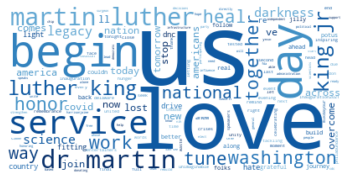

<Figure size 432x288 with 0 Axes>

In [11]:
# Import the packages
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Pull the list together into a single string
Biden_string = ""
Biden_string = ''.join(Biden_df['clean_text'])

# Pull out stopwords from the wordcloud package
stopwords = set(STOPWORDS)

# Create color sheme
cmap_Blues = mpl.cm.Blues(np.linspace(0,1,20))
cmap_Blues = mpl.colors.ListedColormap(cmap_Blues[10:,:-1])

# Make the text object    
Biden_wordcloud_test = WordCloud(stopwords=stopwords, background_color="white", colormap=cmap_Blues).generate(Biden_string)

# set plot up
plt.figure(figsize=(6,6))
plt.imshow(Biden_wordcloud_test, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.clf()

### Getting rid of some words in the word cloud

(-0.5, 399.5, 199.5, -0.5)

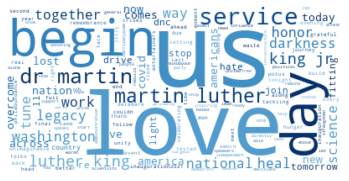

In [12]:
# Add more stopwords - "let", "will"
stopwords.update(["will"])

Biden_wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap=cmap_Blues).generate(Biden_string)

plt.figure(figsize=(6,6))
plt.imshow(Biden_wordcloud, interpolation='bilinear')
plt.axis("off")


### Downloading the plot

In [13]:
from google.colab import files
import time

timestr = time.strftime("%Y%m%d-%H%M%S")
Biden_filename = 'Biden_wordcloud_' + timestr + '.png'
print(Biden_filename)

Biden_wordcloud.to_file(Biden_filename)
files.download(Biden_filename)

plt.clf()

Biden_wordcloud_20210125-152117.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

## Wordcloud Trump

In [14]:
## Pull the list together into a single string
Trump_string = ''.join(Trump_df['clean_text'])    

# Reset stopwords by pulling them again from the wordcloud package
stopwords = set(STOPWORDS)

# Set color sheme
cmap_Reds = mpl.cm.Reds(np.linspace(0,1,20))
cmap_Reds = mpl.colors.ListedColormap(cmap_Reds[10:,:-1])

# Make the text object    
Trump_wordcloud_test = WordCloud(stopwords=stopwords, background_color="white", colormap=cmap_Reds).generate(Trump_string)

# set plot up
plt.figure(figsize=(6,6))
plt.imshow(Trump_wordcloud_test, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.clf()

ValueError: ignored

### Getting rid of some words in the word cloud

In [ ]:
# Add more stopwords - "will"
stopwords.update(["will"])

Trump_wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap=cmap_Reds).generate(Trump_string)

plt.imshow(Trump_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(6,6))
plt.show()

### Downloading the plot

In [ ]:
Trump_filename = 'Trump_wordcloud_' + timestr + '.png'
print(Trump_filename)

Trump_wordcloud.to_file(Trump_filename)
files.download(Trump_filename)

plt.clf()

# Histogram of sentiments

In [ ]:
import seaborn as sns

hue_colors = {'Biden':'#0015BC', 'Trump':'#ff0803'}

sns.set_style("white")
sns.set_context('notebook')

sentiments_hist = sns.displot(data=BidenTrump_df, kind="hist", 
                              x="sentiment_compound", col="person", 
                              hue="person", palette=hue_colors,
                              legend=False)

sentiments_hist.fig.suptitle("Sentiment Distribution of Twitter Activity", y=1.03)
sentiments_hist.set_titles("{col_name}")
sentiments_hist.set(xlabel="Negative Sentiments <---> Positive Sentiments", ylabel="Frequency")
#sentiments_hist.set(xlim=(-1, 1))

## Downloading the plot

In [ ]:
Hist_filename = 'SentimentHistogram_' + timestr + '.png'
print(Hist_filename)

sentiments_hist.savefig(Hist_filename)
files.download(Hist_filename)

plt.clf()

# Most negative and most positive tweets

In [ ]:
Biden_pos = Biden_df.iloc[Biden_df['sentiment_compound'].idxmax(),4]
Biden_neg = Biden_df.iloc[Biden_df['sentiment_compound'].idxmin(),4]

Trump_pos = Trump_df.iloc[Trump_df['sentiment_compound'].idxmax(),4]
Trump_neg = Trump_df.iloc[Trump_df['sentiment_compound'].idxmin(),4]

extremeSentiments_filename = 'extreme_sentiments_' + timestr + '.txt'

extremeSentiments_string = ("Biden positive: \t" + Biden_pos + "\n\n" + 
                            "Biden negative: \t" + Biden_neg + "\n\n" + 
                            "Trump positive: \t" + Trump_pos + "\n\n" + 
                            "Trump negative: \t" + Trump_neg + "\n\n")

extremeSentiments_file = open(extremeSentiments_filename, "w")
extremeSentiments_file.write(extremeSentiments_string)
extremeSentiments_file.close()

files.download(extremeSentiments_filename)

print("Biden positive:", Biden_pos)
print("Biden negative:", Biden_neg)
print("Trump positive:", Trump_pos)
print("Trump negative:", Trump_neg)


# Bivariate plot of sentiment and reach

## Favorites by Sentiment

In [ ]:
sns.set_context('notebook')
sns.set_style('whitegrid')

favorite_biplot = sns.lmplot(data=BidenTrump_df, x="sentiment_compound", y="favorite_count", 
            col="person", hue="person", palette=hue_colors, legend=False, order=2, ci=None,
            line_kws={'color': 'black'})

favorite_biplot.fig.suptitle("Favorite Count by Sentiment", y=1.03)
favorite_biplot.set_titles("{col_name}")
favorite_biplot.set(xlabel="Negative Sentiments <---> Positive Sentiments", ylabel="Favorite Count")
favorite_biplot.set(ylim=(0,None))

### Downloading the plot

In [ ]:
favorite_biplot_filename = 'favorite_biplot_' + timestr + '.png'
print(favorite_biplot_filename)

favorite_biplot.savefig(favorite_biplot_filename)
files.download(favorite_biplot_filename)

plt.clf()

## Retweet by Sentiment

In [ ]:
sns.set_style('whitegrid')
sns.set_context('notebook')

retweet_biplot = sns.lmplot(data=BidenTrump_df, x="sentiment_compound", y="retweet_count", 
            col="person", hue="person", palette=hue_colors, legend=False, order=2, ci=None,
            line_kws={'color': 'black'})

retweet_biplot.fig.suptitle("Retweet Count by Sentiment", y=1.03)
retweet_biplot.set_titles("{col_name}")
retweet_biplot.set(xlabel="Negative Sentiments <---> Positive Sentiments", ylabel="Retweet Count")
retweet_biplot.set(ylim=(0,None))

### Downloading the plot

In [ ]:
retweet_biplot_filename = 'retweet_biplot_' + timestr + '.png'
print(retweet_biplot_filename)

retweet_biplot.savefig(retweet_biplot_filename)
files.download(retweet_biplot_filename)

plt.clf()

# Sentiment over recent days

In [ ]:
from collections import deque

sns.set_context('notebook')
sns.set_style('whitegrid')


sentiment_date = sns.relplot(data=BidenTrump_df, kind="line", x="date", 
                             y="sentiment_compound", hue="person",
                             palette=hue_colors, ci=None, legend=True,
                             aspect=2, linewidth = 2.5)

date_list = deque()

for date in BidenTrump_df.date.unique():
  date_list.appendleft(date.strftime("%d/%m"))

sentiment_date.set_xticklabels(date_list)

sentiment_date.fig.suptitle("Sentiment Development over Recent Days", y=1.03)
sentiment_date.set_titles("{col_name}")
sentiment_date.set(xlabel="Date", ylabel="Negative Sentiments <---> Positive Sentiments")
#sentiment_date.set(ylim=(-1, 1))
sentiment_date.set_xticklabels(rotation=90)
sentiment_date._legend.set_title('Person')



## Downloading the plot

In [ ]:
sentiment_date_filename = 'sentiment_date_' + timestr + '.png'
print(sentiment_date_filename)

sentiment_date.savefig(sentiment_date_filename)
files.download(sentiment_date_filename)

plt.clf()

# Sentiment over an average day

In [ ]:
sentiment_hour = sns.relplot(data=BidenTrump_df, kind="line", x="hour", 
                             y="sentiment_compound", col="person", hue="person",
                             palette=hue_colors, ci="sd", legend=False)

sentiment_hour.fig.suptitle("Sentiment Development over an Average Day", y=1.03)
sentiment_hour.set_titles("{col_name}")
sentiment_hour.set(xlabel="Hour of the Day", ylabel="Negative Sentiments <---> Positive Sentiments")
sentiment_hour.set(xlim=(7, 23))


## Downloading the plot

In [ ]:
sentiment_hour_filename = 'sentiment_hour_' + timestr + '.png'
print(sentiment_hour_filename)

sentiment_hour.savefig(sentiment_hour_filename)
files.download(sentiment_hour_filename)

plt.clf()